# EEML'24: **Reasoning** Tutorial
---
**Authors**:
* Matko Bošnjak (matko@google.com)
* Petar Veličković (petarv@google.com)


## Motivation

In this tutorial, we will explore the wonderful and challenging domain of **algorithmic reasoning** 🔢 with deep neural networks 🤖.

You have already seen in the introductory lecture how even our **strongest** frontier models tend to struggle on seemingly _simple_ reasoning tasks. This might come as a surprise---these models were trained on the entirety of the Internet, which certainly contains **many** traces of reasoning.

We will carefully elaborate why this might be happening, and illustrate how evaluating reasoning is a much more involved task than the usual train/test paradigm for many other deep learning tasks.

Since it is the first tutorial in this year's EEML, beyond exploring reasoning, we will also use it to teach you some foundational aspects of training deep neural networks at an abstract level: data preparation, training/validation/testing, as well as writing your own training loop.

## Outline

- What even _is_ reasoning?
- Setup and installation of necessary Python libraries.
- Practical 1: How can we train a model to robustly execute computation?
- Practical 2: Exploration of model / algorithm variations
- Practical 3: Algorithmically tuning a large language model

❗ Note: While a GPU is not mandatory for this tutorial, we recommend using it to speed up the training. You can do this by clicking `Runtime -> Change runtime type`, and set the hardware accelerator to GPU.

## What even _is_ reasoning?
---

In order to be able to talk about how we can build systems capable of reasoning, and evaluate their reasoning capabilities, it is useful to step back and ponder on what reasoning even _is_. 🧠

Unfortunately, here we hit a bit of a 🚧 _roadblock_ 🚧: if you ask 100 AI practitioners what reasoning is, you're very likely to get 100 different answers. 🙂

However, if you're willing to trust the two of us _[and it might make sense to do so, as we've worked on reasoning for many years before it became a hot topic!]_, we could try to go forward with our definition of reasoning.

So, what does reasoning mean to _Matko and Petar_?

### Reasoning is a **robust** procedure for solving instances of a problem.

The key word we focus on here is **robust**:

* It needn't be fully accurate _(humans can reason, and human reasoning is often approximate!)_
* It needn't be symbolic _(i.e. the model does not need to explicitly produce its explanations to be considered a reasoning system)_

But it should behave **consistently** across all relevant instances of a reasoning problem.

**Note that this involves testing how the system will behave _outside_ of any particular dataset we've been able to collect!**

This is a very important point:

### ❗ "Solving reasoning" is **much harder** than maximising static benchmarks related to reasoning ❗

And as we've seen during the introductory lecture, even adding simple spurious information to a reasoning prompt, or slightly increasing the size of the problem, can completely throw off frontier LLMs, without any decrease in their apparent confidence.

Just as a simple example, here is the recorded accuracy of prompting GPT-4 on $n$-by-$n$-digit multiplication without letting it use tools, which illustrates a particularly pain-staking point ([Shen _et al._, 2023](https://arxiv.org/abs/2311.14737)):

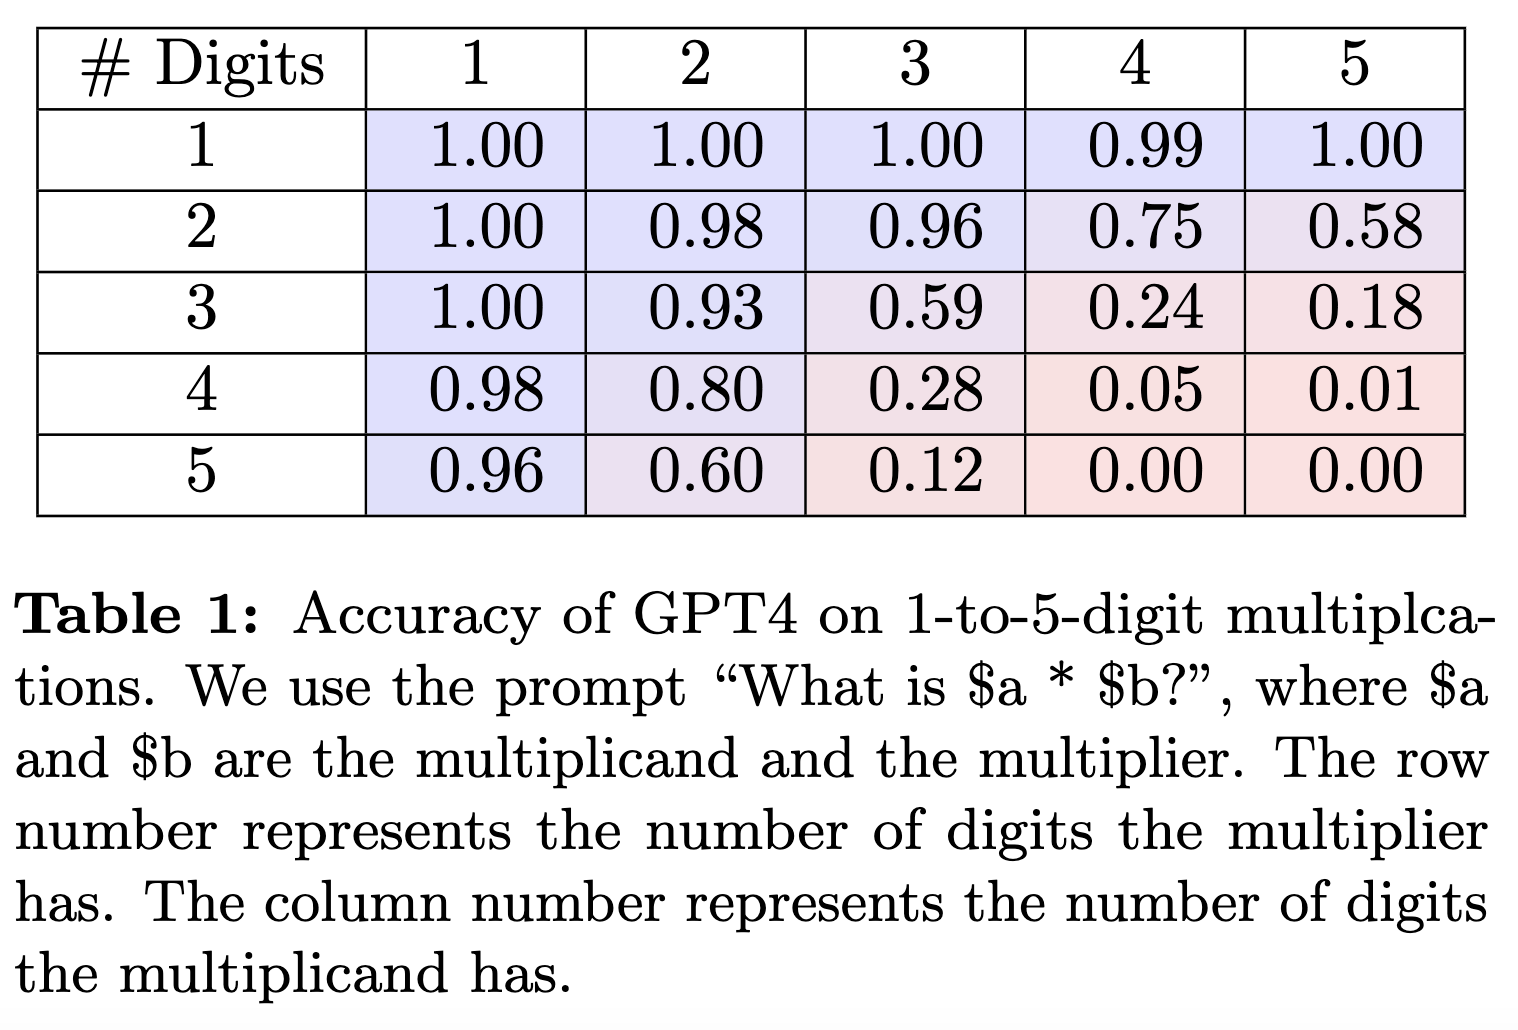

### Transformers compute _hundreds of billions_ of multiplications just to compute a **single** token, yet they cannot reliably multiply 3-by-3-digit numbers. 😱

Now, we shall investigate how to explicitly train models for performing reasoning better, and also how to robustly evaluate them.

## Setup and installation of necessary Python libraries
---

According to the above, our aim for this tutorial is to evaluate how well our models will behave on _**dynamically** sampled_ data of various distributions. Further, we seek an elegant framework for expressing training and evaluation on a high level. Fortunately, we have exactly this! 🚀

We will use [The CLRS Algorithmic Reasoning Benchmark](https://github.com/google-deepmind/clrs), a library that includes both the dataset and the models we will experiment with:

`The CLRS Algorithmic Reasoning Benchmark (CLRS) consolidates and extends previous work toward evaluation algorithmic reasoning by providing a suite of implementations of classical algorithms. These algorithms have been selected from the third edition of the standard Introduction to Algorithms by Cormen, Leiserson, Rivest and Stein.`

While this library is written in JAX, you do not need to know the details of its implementation---we will treat both library and the machine learning model as black boxes (of course, we will provide explanations on how specific algorithms we use work).

In [ ]:
!pip3 install -q -U accelerate==0.27.1
!pip3 install -q -U datasets==2.17.0
!pip3 install -q -U transformers==4.38.1
!pip3 install -q -U bitsandbytes==0.42.0 # 0.42 old
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10  # old 0.8.0 no errors
!pip3 install -q -U prettyprinter
!pip3 install -q -U git+https://github.com/google-deepmind/clrs.git

In [ ]:
import clrs
import jax
import jax.numpy as jnp
import numpy as np
import os
import pprint                 # useful for pretty-printing dictionaries :)
import prettyprinter as pp    # and this one for namedtuples :)
import random
import torch
import transformers

from clrs._src.clrs_text import clrs_utils
from datasets import Dataset
from google.colab import userdata
from matplotlib import pyplot as plt
from peft import LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from trl import SFTTrainer

# Jax likes to reserve 75% of GPU memory, we need to stop it from doing that
# as we'll need GPU memory in section 3
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

# initialise a JAX random number generator
rng = np.random.RandomState(1234)
rng_key = jax.random.PRNGKey(rng.randint(2**32))

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

## Practical 1: How can we train a model to robustly execute computation?
---

Now that the setup is complete, let's get more familiar with the kind of functionality offered to us by the `clrs` package!

We will start by inspecting the _data_ CLRS provides. Out-of-the-box, CLRS has built-in samplers for [thirty classical algorithms](https://github.com/google-deepmind/clrs/blob/master/clrs/_src/specs.py#L67-L98) [[0]](https://github.com/google-deepmind/clrs/tree/master?tab=readme-ov-file#what-we-provide), spanning a wide range of algorithmic skills. These samplers can then be used to create datasets of arbitrary numbers of examples, and arbitrary problem size.

We will focus on the **Bellman-Ford** algorithm, which is a standard shortest path-finding algorithm encountered in a theoretical computer science degree.

If you need a refresher, the pseudocode for Bellman-Ford---assuming shortest paths exist---is as follows, for a graph $G=(V,E)$ with source node $s$ and edge weights $w : E\rightarrow\mathbb{R}$:

```
Bellman-Ford(G, w, s)
  // initialise: all nodes are infinitely away from the source
  for each vertex v in G
    d[v] = ∞
    π[v] = NIL
  // initialise: the source is a distance zero from itself
  d[s] = 0

  repeat
    // attempt to relax each edge, u -> v, in the graph
    for each edge (u, v) in G
      // if there is a shorter path to v via u
      if d[v] > d[u] + w[u, v]
        // this is the new shortest path to v
        d[v] = d[u] + w[u, v]
        // u becomes the new predecessor of v
        π[v] = u
  until d[v] does not change
  // NB. if G has a negative-weight cycle, this loop will never terminate!

  return π
```

Here we provide a short implementation to construct the samplers. Note that we explicitly make the test instances find shortest paths in **larger** graphs than the training and validation data---this allows us to test **out-of-distribution** behaviour.

In [ ]:
# Build the training samplers and specs
train_sampler, spec = clrs.build_sampler(
    name='bellman_ford',  # the algorithm we're using
    num_samples=-1,       # the training dataset is unlimited (-1 samples)
    length=16)            # the problem size (arrays of 16 elements)

# Build the validation sampler and spec
val_sampler, spec = clrs.build_sampler(
    name='bellman_ford',  # the algorithm we're using
    num_samples=100,      # the validation dataset has 100 samples
    length=16)            # the validation set is 'in-distribution'

# Build the test sampler and spec
test_sampler, spec = clrs.build_sampler(
    name='bellman_ford',  # the algorithm we're using
    num_samples=100,      # the test set has 100 samples
    length=64)            # the test set is 'out-of-distribution'!

# Helper function to continuously sample data from the sampler
def _iterate_sampler(sampler, batch_size):
  while True:
    yield sampler.next(batch_size)  # Collect batch_size many samples

train_sampler_iter = _iterate_sampler(train_sampler, batch_size=32)  # Minibatch
val_sampler_iter = _iterate_sampler(val_sampler, batch_size=100)     # Fullbatch
test_sampler_iter = _iterate_sampler(test_sampler, batch_size=100)   # Fullbatch

The CLRS samplers do not only produce input-output pairs; they also expose the _entire trace_ of the algorithm's state during execution.

As an example, here is a CLRS trace of executing Bellman-Ford on a graph of five nodes, from a source node:

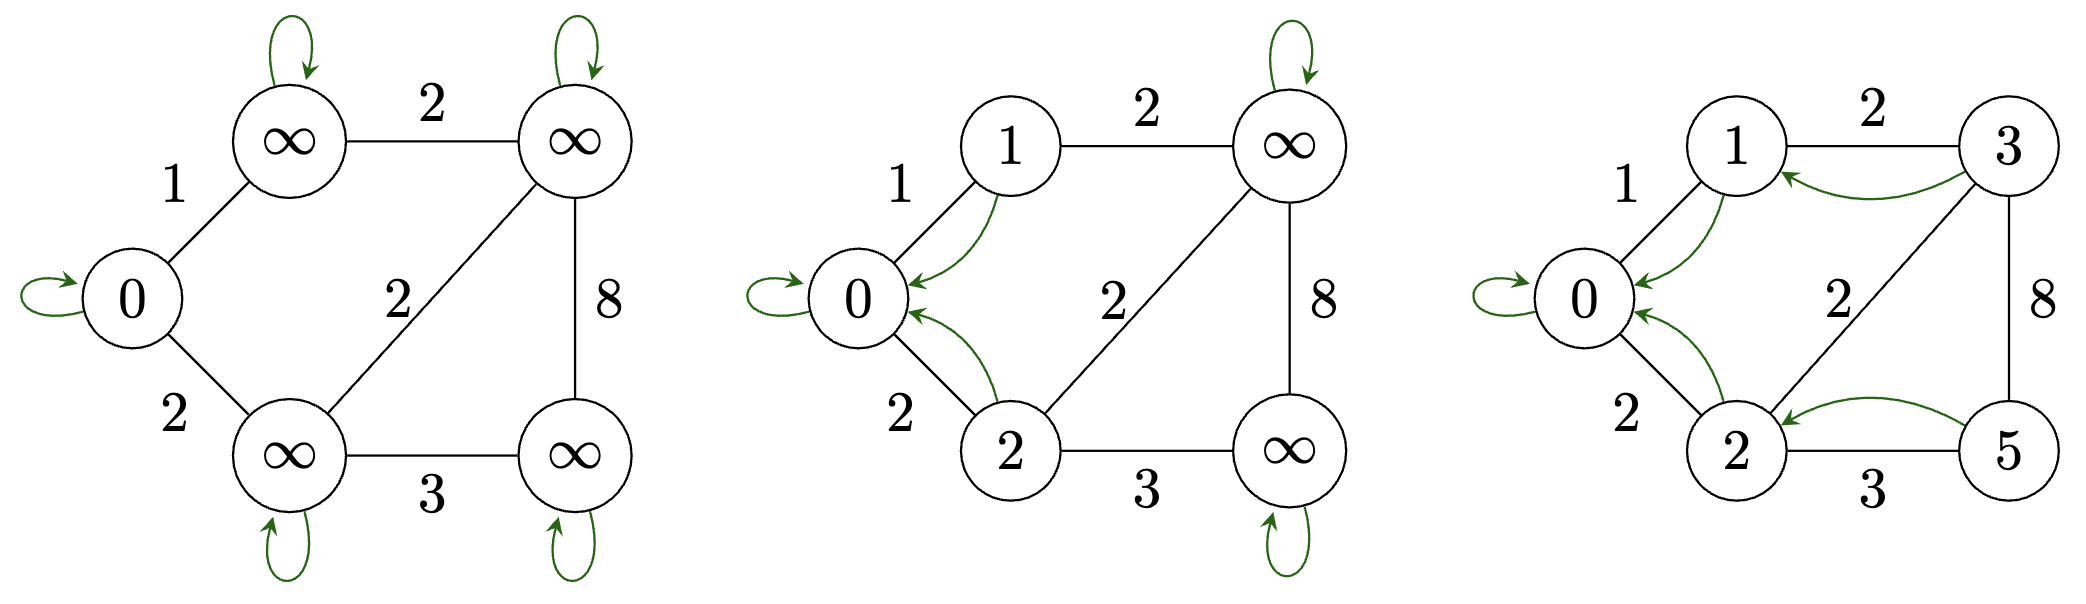

In this figure, you may notice some of the information captured by CLRS in every step of the way:

* The edge weights of the graph (represented as the the values on links between nodes);
* The current shortest path distances (represented as values in the nodes);
* Which nodes have not been reached so far (represented as "infinity" values in the nodes);
* The predecessor pointers of the shortest paths (represented as **green** arrows);

You may have noticed that the `clrs.build_sampler` function returns a mysterious `spec` object. It turns out that this dictionary object is a very convenient way to list all the information that CLRS records about the algorithm!

Let's print this information -- please have a go at mapping what the various parts of the dictionary might be referring to!

In [ ]:
pprint.pprint(spec)  # Print out the spec of the algorithm

Now, let's actually peek at what's inside the data!

We'll sample a batch of 32 trajectories (on arrays of length 16) using our previously constructed `train_sampler`.

We also provide a few bits of investigation into what may be found inside this data batch -- we encourage you to probe around this data further!

In [ ]:
data_batch = next(train_sampler_iter)  # sample a 16-node data batch

print(data_batch.features)  # the trace features in the batch
print(data_batch.outputs)   # the outputs for the data in the batch

##############################################################################
# If you'd like to peek further inside the data points, you may do so here :)
# We recommend investigating the trace (data_batch.features.hints) especially.
# YOUR CODE HERE
##############################################################################

Now that we've examined the data, it is time to construct our first machine learning model over this data -- the **Deep Sets** architecture!

The Deep Sets model assumes we have data from $N$ nodes, with features specified by a matrix $\mathbf{X}\in\mathbb{R}^{N\times k}$; such that $\mathbf{x}_u\in\mathbb{R}^k$ are the features of node $u$.

A single layer of Deep Sets then simply processes each node's features separately:

$$\mathbf{h}_u = \psi(\mathbf{x}_u)$$

using a shared function, $\psi : \mathbb{R}^k\rightarrow\mathbb{R}^l$. In practice, $\psi$ is typically implemented as a fully-connected layer:

$$\psi(\mathbf{x}) = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$$

where $\mathbf{W}\in\mathbb{R}^{l\times k}$ and $\mathbf{b}\in\mathbb{R}^l$ are the learnable weight and bias parameters of the model, and $\sigma$ is an activation function, such as $\mathrm{ReLU}(x) = \max(0, x)$.

CLRS is very convenient for building models like these, because all we have to do is specify some of its hyperparameters---the library will take care of constructing all other necessary encoders, decoders and loss functions and gradient descent routines that the model might require.

Let's get to it!

In [ ]:
# A factory is a convenience function to help us generate new models:
processor_factory = clrs.get_processor_factory(
    'deepsets',        # We'd like to create the Deep Sets model factory
    nb_triplet_fts=0,  # No triplet features used for now
    use_ln=True)       # Use layer normalisation (important for convergence)

# Using this, we can create a dictionary with all the key hyperparameters
model_params = dict(
    processor_factory=processor_factory,  # Our factory function
    hidden_dim=32,                        # The latent dimension (k, l above)
    encode_hints=True,                    # Should we encode the trace?
    decode_hints=True,                    # Should we decode/learn on the trace?
    encoder_init='default',               # How to initialise the encoder
    hint_teacher_forcing=0.0,             # Teacher forcing probability
    use_lstm=False,                       # Use LSTM across trace timesteps?
    learning_rate=0.001,                  # Base learning rate for Adam
    grad_clip_max_norm=0.0,               # Maximum norm of gradient before clip
    checkpoint_path='/tmp/checkpt',       # Where to store model checkpoints?
    dropout_prob=0.0,                     # Dropout probability
)

# Now we can create the model itself using these parameters
model = clrs.models.BaselineModel(
    spec=spec,                    # Use the spec to tell us how to encode/decode
    dummy_trajectory=data_batch,  # JAX requires example trace to initialise
    **model_params                # Our model parameter dictionary
)

# Calling model.init(inputs, seed) initialises the parameters of the model.
model.init(data_batch.features, 1234)

Now we come to the first task for you all -- constructing a **training loop**. Our emphasis here is to understand a model training loop on a _conceptual_ level rather than diving into details; conveniently, the `model`s created by CLRS processor factories have [abstractions](https://github.com/google-deepmind/clrs/blob/master/clrs/_src/model.py) that perform key tasks needed to train a model.

We particularly emphasise:
* `loss = model.feedback(rng_key, batch)`: Performs one step of gradient descent on the `model` using the training data contained in the `batch`. As a convenience, it returns the `loss` of the model on these data points.
* `predictions, hint_predictions = model.predict(rng_key, features)`: Performs the forward pass of the `model` on the input features given by `features`. It returns both the output `predictions` and the predicted trace (`hint_predictions`).

Note that both of these functions expect a `rng_key` argument---this is an artefact of JAX and you do not need to be concerned with manipulating it. We already provide code to properly handle RNG keys below.

Additionally, `clrs` provides a convenient function, `accuracy = clrs.evaluate(outputs, predictions)`, which will compute accuracy on a particular batch of data, where the ground-truth outputs are given by `outputs` and the model's predictions by `predictions`.

For Bellman-Ford specifically, the model will be asked to predict the predecessor of each node in the shortest paths from the source to it. The accuracy is measured on the per-node level---i.e. it will let you know how many nodes had their predecessors predicted accurately.

Using these abstractions, now it's your turn to build the training loop! Please fill in the skeleton below accordingly:

In [ ]:
step = 0
best_val_acc = -1.0

# Collect all observed losses, and accuracies here for plotting purposes
train_losses = []
val_accs = []

while step <= 500:  # Train for 500 gradient descent steps
  ################################################################
  # collect a new training sample, using the next() function
  # YOUR CODE HERE
  ################################################################
  # ANSWER
  train_batch = next(train_sampler_iter)
  ################################################################
  # generate a new RNG key (needed for calling the model)
  rng_key, new_rng_key = jax.random.split(rng_key)
  ################################################################
  # perform one step of gradient descent, using model.feedback()
  # and collect the loss into train_losses
  # YOUR CODE HERE
  ################################################################
  # ANSWER
  cur_loss = model.feedback(rng_key, train_batch)
  train_losses.append(cur_loss)
  ################################################################
  if step % 50 == 0:  # Record validation metrics every 50 steps
    ##############################################################
    # collect the validation set, using the next() function
    # YOUR CODE HERE
    ##############################################################
    # ANSWER
    val_batch = next(val_sampler_iter)
    ##############################################################
    # collect the validation predictions, using model.predict()
    # then compute their accuracy against ground-truth outputs
    # using clrs.evaluate(); collect the accuracy into val_accs
    # YOUR CODE HERE (set current_val_acc)
    ##############################################################
    # ANSWER
    predictions_val, _ = model.predict(rng_key, val_batch.features)
    out_val = clrs.evaluate(val_batch.outputs, predictions_val)
    current_val_acc = out_val["score"]
    val_accs.append(current_val_acc)
    ##############################################################
    # print the current step, train loss and validation accuracy
    # YOUR CODE HERE
    ##############################################################
    # ANSWER
    print(f'step = {step} | loss = {cur_loss} | val_acc = {out_val["score"]}')
    if best_val_acc < current_val_acc:  # new best model found
      ############################################################
      # collect the test set, using the next() function
      # YOUR CODE HERE
      ############################################################
      # ANSWER
      test_batch = next(test_sampler_iter)
      ############################################################
      # evaluate accuracy against ground-truth on the test set
      # YOUR CODE HERE (set test_acc)
      ############################################################
      # ANSWER
      predictions_test, _ = model.predict(rng_key, test_batch.features)
      out_test = clrs.evaluate(test_batch.outputs, predictions_test)
      test_acc = out_test["score"]
      ############################################################
      best_val_acc = current_val_acc
  step += 1

print(f'Final test accuracy: {test_acc}')

Let's plot how our training progressed, using the data you collected in `train_losses`, `val_accs` and `test_acc`!

In [ ]:
plt.plot(train_losses, label='Train loss', color='b')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.figure()

plt.plot([s * 50 for s in range(len(val_accs))],
         val_accs, label='Validation accuracy', color='r')
plt.axhline(y=test_acc, linestyle='--', label='Test accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

If everything goes well, you should see your loss steadily going down 📉 and your validation accuracy gradually increasing 📈! Congrats! 🎉

However, you may also notice your final _test_ accuracy is substantially lower than your validation accuracy -- a clear sign that the model has learnt some specifics about how to find shortest paths at 16 nodes, but not in a way that generalises well to 64 nodes.

## Practical 2: Exploration of model / algorithm variations
---

Now let's explore some ways to improve the reasoning capabilities of our model on the Bellman-Ford task!

We will start by providing one recommended way in which you can immediately see returns---but we encourage you to then explore further. Some of the findings you discover may be **counterintuitive**: please do let us know what you find at the end of the session! 😊

You might have noticed 👀 something _odd_ about the formulation of the Deep Sets w.r.t. the Bellman-Ford task: namely, **only** node features are assumed, while the trace for Bellman-Ford also has information about the path lengths in the graph, and these concern _relations_ between nodes (**edge features**).

Hence, the Deep Sets model is explicitly _discarding_ this information from its inputs, and does not model relations between the nodes at all. It is worthwhile to expect our reasoning performance to improve once we allow for these interactions 🕸.

Within the directly available [CLRS processor factories](https://github.com/google-deepmind/clrs/blob/master/clrs/_src/processors.py#L735-L902), we can use the **message passing neural network** (MPNN) as a representative example.

You will learn _a lot_ more about MPNNs in the **Geometric Deep Learning** tutorial later this week... but as a quick introduction, we provide the MPNN model equations on a high level:

Just as in the Deep Sets setup, we assume we have access to node features $\mathbf{X}\in\mathbb{R}^{N\times k}$ for a graph of $N$ nodes. However, now we also assume access to _edge features_, $\mathbf{E}\in\mathbb{R}^{N\times N\times k}$, with $\mathbf{e}_{uv}\in\mathbb{R}^k$ the feature of edge $u\rightarrow v$.

A single MPNN layer now takes into account _pairwise interactions_:

$$\mathbf{h}_u = \phi\left(\mathbf{x}_u, \bigoplus_{1\leq v\leq N}\psi\left(\mathbf{x}_u, \mathbf{x}_v, \mathbf{e}_{vu}\right)\right)$$

where $\psi : \mathbb{R}^k\times\mathbb{R}^k\times\mathbb{R}^k\rightarrow\mathbb{R}^k$ is a _message function_, computing the feature vector sent from node $v$ to node $u$.

All messages arriving at node $u$ are then combined using the _aggregation function_ $\bigoplus : \mathrm{bag}(\mathbb{R}^k)\rightarrow\mathbb{R}^k$, which is typically chosen to not depend on the order in which messages are processed; CLRS typically uses $\bigoplus=\max$.

Lastly, $\phi : \mathbb{R}^k\times\mathbb{R}^k\rightarrow\mathbb{R}^k$ is an _update function_ which updates the node's features based on the aggregated messages.

We provide the code to load an MPNN model factory, and you may use it as a starting point to investigate this, and many other hyperparameter changes 🚀

In [ ]:
# Making a new processor factory for PGNs:
mpnn_processor_factory = clrs.get_processor_factory(
    'mpnn',            # We'd like to create the MPNN model factory
    nb_triplet_fts=0,  # No triplet features used for now
    use_ln=True)       # Use layer normalisation (important for convergence)

##############################################################################
# Add any additional code necessary here, or modify relevant hyperparameters.
# YOUR CODE HERE
##############################################################################

We invite you to explore at least 2--3 other changes to the model or training setup---as some suggestions, you may explore variations in:
* the training data sampler(s) (using `clrs.build_sampler`);
* the model factory parameters (using `clrs.get_processor_factory`);
* the model hyperparameters (in `model_params`).

To keep your results consistent, comparable and rapid, we suggest not changing the number of training steps or the frequency of evaluation.

In [ ]:
##############################################################################
# Add any additional experimental code here.
# YOUR CODE HERE
##############################################################################

Please note down your findings and share them with your TAs and the rest of your cohort towards the end of the session!

If you have some time left, we also provide a _third_ part of this practical, which is designed to take what you've accomplished with CLRS processor networks and apply it in the **large language model** domain 🗣

## Practical 3: Algorithmically tuning a language model
---

We started the tutorial by showing how our strongest foundational models struggle with reasoning tasks, and guided you to models which are a significantly better fit for these tasks. 🤖🧠💪

Now, as good scientists we have to ask ourselves: _can we in some way improve those same foundational models to be better at reasoning?_

One obvious way to improve them is to simply train them on more reasoning data 📚. Will that actually improve them? To some extent, as we mentioned before. Will that _drastically_ improve their reasoning capabilities? 🤷 Some researchers think affirmatively, given enough data, but we think this won't happen.

There are still many reasons to do this, however: it's fun, a useful skill to know -- you can jump-start your projects with a bit of fine-tuning! 🚀 -- and with a good amount of research, we can perhaps improve them to the point of performing satisfactory for a particular use case.

Let's get to it then! 🙌

In this section we will fine-tune Google's open-sourced large language model, [Gemma](https://ai.google.dev/gemma/) \([Team, Gemma, et al. 2024](https://arxiv.org/abs/2403.08295)\)


**N.B.** This section is based on [Fine-Tuning Gemma Models in Hugging Face](https://huggingface.co/blog/gemma-peft) [[colab](https://huggingface.co/google/gemma-7b/blob/main/examples/notebook_sft_peft)].

In order to fine-tune Gemma, we first need to obtain permissions to _use it_, by setting up a few things...

1. [Log in to Hugging Face](https://huggingface.co/login). You will need to **register**, if you don't already have an account there.

2. Go to the [Gemma-2B website](https://huggingface.co/google/gemma-2b) and sign the **model use agreement** (if you agree with its terms, ofc!), as Gemma is a gated model.

3. Go to the [settings](https://huggingface.co/settings/tokens) tab and create a **new access token** for model reading at least. We will need this token to access the model (and it will generally be useful to have in several subsequent EEML tutorials!). Make sure to copy the token into your clipboard.

Once you're done with these steps, you're almost ready to go. There's only one thing outstanding: you need to **copy** the security token in this Colab.

We won't be blatantly copy-pasting it here into a variable, since we could inadvertently share it with the rest of the world on GitHub or elsewhere, and this is private / sensitive data that should _never_ be shared 🤫.

Instead, we will use Colab's Secrets to save it privately 🔒:
- click on the Secrets (🔑) in the left side-menu
- click on `Add new secret`
- name it `HF_TOKEN`, paste the HuggingFace token into it, and give access to it to this notebook.

For more details on how to use Secrets, you may check [this](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75) article.

Now we can use the token in our code accordingly:

In [ ]:
# Save your private / sensitive data using Secrets 🔑
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

And we can finally download the Gemma 2B model. Note this might take a few minutes, depending on the speed of your Internet connection (the model checkpoint occupies 5 GB).

In [ ]:
model_id = "google/gemma-2b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    token=os.environ['HF_TOKEN'])

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"":0},
    token=os.environ['HF_TOKEN'])

Let's start playing with our loaded model.

We will start by prompting it on a specific sentence, such as `What would you be if you could be whatever you want to be?`. Before running inference on this, have a think: what do you think what the output for the following particular prompt might look like?

In [ ]:
prompt = "What would you be if you could be whatever you want to be?"
device = "cuda:0"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Did you expect this particular style of output? If either yes or no, why?

Now that the model is loaded, we can start investigating its reasoning capabilities on our algorithmic reasoning data.

To do this, we need to prepare our CLRS data in a digestible format for the LLM---and the first step towards this is to convert it into **text**. Let's first set up CLRS samplers as we did before (note, we will be using a significantly smaller size here).


In [ ]:
# Build the training samplers and spec
train_text_sampler, spec = clrs.build_sampler(
    name='bellman_ford',  # let's stick with bellman_ford again
    num_samples=100,      # limit it to 100 examples for this practice...
    length=3)             # and drastically lower the problem size to save time

# Build the validation sampler and spec
val_text_sampler, spec = clrs.build_sampler(
    name='bellman_ford',
    num_samples=100,
    length=3)             # we stay in-distribution, this will already be hard

# Helper function to continuously sample data from the sampler
def _iterate_sampler(sampler, batch_size):
  while True:
    yield sampler.next(batch_size)  # Collect batch_size many samples

In [ ]:
# Note, for the text conversion to work properly, batch_size must remain 1
example_sampler_iter = _iterate_sampler(val_text_sampler, batch_size=1)
# this is our standard training data as in Section 1
datum = next(example_sampler_iter)
pp.pprint(datum)

Now that we have CLRS traces, we want to convert them into a textual form. For the trace of Bellman-Ford we saw before, this might look like this (prompt in green, trace in blue, output in red).

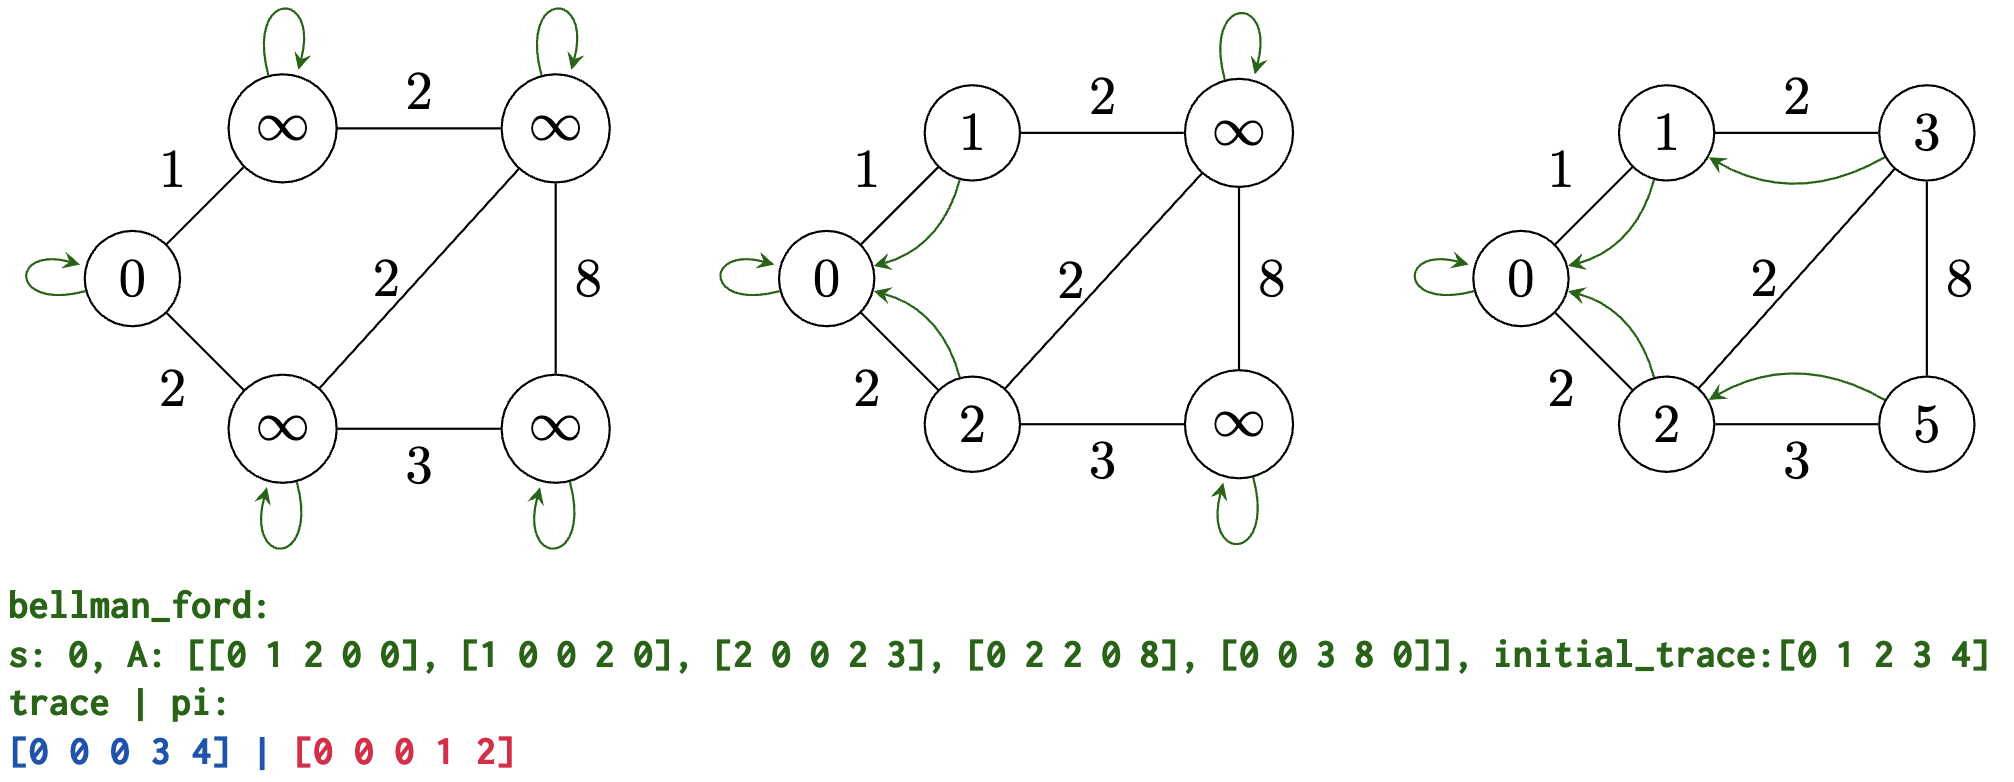

CLRS conveniently provides us exactly this converter -- through the [CLRS-Text](https://arxiv.org/abs/2406.04229) benchmark.

Specifically, we will be using the function `clrs_utils.format_clrs_example` to perform the conversion directly:

In [ ]:
datum_text = clrs_utils.format_clrs_example(
    "bellman_ford",   # the identity of the algorithm
    datum,            # the CLRS trace being converted
    use_hints=False)  # whether or not to print the trace

print(f"Input: {datum_text[0]}")
print(f"Output: {datum_text[1]}")

Now we can use `clrs_utils.format_clrs_example` to create an _iterative_ text sampler that can constantly produce textual data given a CLRS sampler. We leave this as an exercise to you:

In [ ]:
# Helper function to continuously sample text data from the sampler
def _iterate_text_sampler(sampler):
  for _ in range(sampler._num_samples):
    ##############################################################
    # rewrite the iterator code so that it outputs samples in text
    # remember, batch_size must be 1 for this to work!
    # YOUR CODE HERE
    ##############################################################
    # ANSWER
    text_sample = clrs_utils.format_clrs_example(
        "bellman_ford",
        sampler.next(1),
        use_hints=False)
    ##############################################################
    yield {'text': f"Input: {text_sample[0]}\nOutput: {text_sample[1]}"}


train_text_sampler_iter = _iterate_text_sampler(train_text_sampler)
val_text_sampler_iter = _iterate_text_sampler(val_text_sampler)

If everything was implemented correctly, the following line should yield a CLRS textual trace.

In [ ]:
pprint.pprint(next(val_text_sampler_iter))

How do you expect the Gemma 2B model will respond to such a prompt out of the box?

Let's investigate:

In [ ]:
datum_text = clrs_utils.format_clrs_example("bellman_ford", datum, use_hints=False)

##############################################################
# run the pre-trained Gemma 2B on datum_text specifying input
# but forcing the model to produce the output
# (i.e. do not specify output ;))
# YOUR CODE HERE
##############################################################
# ANSWER
##############################################################
prompt = f"Input: {datum_text[0]}\nOutput: "
device = "cuda:0"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Can you interpret what the model is doing? Any hypotheses for why it is behaving in this way?

Now that our dataset sampling is ready, we can get started **fine-tuning** Gemma to respond to CLRS-Text traces!

First, we need to create a Hugging Face `Dataset` using our sampler -- luckily, the HF API has methods that allow us to do this in a streamlined manner.

Then, as you are probably aware by now, LLMs do not process raw characters of text: rather, they process **tokens**: chunks of text carefully chosen to represent a diverse and flexible, but tractable vocabulary for the model to work with.

To fully prepare our data in an LLM-digestible format, we hence need to **tokenize** it. Once again, conveniently, HF provides a `tokenizer` API out of the box to do just this 🙂

In [ ]:
# First, use our previously built iterator to construct a Dataset
ds_train = Dataset.from_generator(
    _iterate_text_sampler,
    gen_kwargs={'sampler': train_text_sampler})

# Then, feed each sample through a tokenizer to make it LLM-compatible
ds_train = ds_train.map(
    lambda samples: tokenizer(samples["text"]),
    batched=True)

Now we are ready to kick off our fine-tuning job (using HF's `SFTTrainer` object)!

This API handles a supervised fine-tuning (SFT) training loop for us automatically---all we have to do is provide a model, dataset, hyperparameters and details of the fine-tuning method used.

Here we will specifically use a parameter-efficient fine-tuning (PEFT) method known as [quantized low-rank adaptation](https://huggingface.co/blog/4bit-transformers-bitsandbytes) (QLoRA) [[paper](https://arxiv.org/abs/2305.14314)].

QLoRA is a suitable method for a small-scale investigation, as it keeps most of the parameters of the LLM _frozen_ and only updates a specific subset of them.

We will not focus on QLoRA more in this Colab, but invite you to find out more about it in your own spare time!

In [ ]:
# Define the (Q)LoRA configuration used for our fine-tuning job
lora_config = LoraConfig(
    r=8,                    # Rank of the LoRA algorithm
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj",  # Which modules of
                    "gate_proj", "up_proj", "down_proj"],    # the LLM to update
    task_type="CAUSAL_LM",  # Next-token prediction with a causal mask
)

# Note Q part of the QLoRA parameters have been specified in `bnb_config`

# A helper formatting function for the SFT Trainer
def formatting_func(example):
    return example['text']

# Define the SFTTrainer object used for the supervised fine-tuning loop
trainer = SFTTrainer(
    model=model,                          # the model we're tuning
    train_dataset=ds_train,               # the dataset we're tuning on
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,    # the batch size of training
        gradient_accumulation_steps=4,    # steps to accumulate gradients for
        warmup_steps=2,                   # steps to warmup learning rate for
        max_steps=50,                     # maximal number of learning steps
        learning_rate=2e-4,               # base learning rate for AdamW
        fp16=True,                        # use 16-bit floating-point precision
        logging_steps=1,                  # how often to log information
        output_dir="outputs",             # where to write model artefacts
        optim="paged_adamw_8bit"          # the specific variant of AdamW to use
    ),
    peft_config=lora_config,              # the (Q)LoRA config we're using
    formatting_func=formatting_func,      # the formatting function we're using
)

# Kick off SFT!!!
trainer.train()

In [ ]:
##############################################################
# plot the loss to see how it's changing
# you can access it in trainer.state.log_history[i]['loss']
# YOUR CODE HERE
##############################################################
# ANSWER
##############################################################

plt.plot([l['loss'] for l in trainer.state.log_history if 'loss' in l], label='Train loss', color='b')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid()
plt.show()

Just as with the graph-based CLRS before, we may be satisfied that the model's loss (this time on next-token prediction) is coming down 📉!

Does this result in any tangible difference to Gemma's output?

Let's investigate:

In [ ]:
datum_text = clrs_utils.format_clrs_example("bellman_ford", datum, use_hints=False)

##############################################################
# run the pre-trained Gemma-2B on datum_text
# YOUR CODE HERE
##############################################################
# ANSWER
##############################################################
prompt = f"Input: {datum_text[0]}\nOutput: "
device = "cuda:0"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

How is the output different to what you've seen before with the base Gemma 2B model? 👀🤔

Does it achieve our aims? Is the model more capable of _"reasoning"_ on CLRS-Text after this kind of fine-tuning?

You may likely wish to run additional variations of fine-tuning and/or prompting the model. While we're well aware of the time constraints of the tutorials, we provide one last blank code block, which you can use to kick off some investigations with CLRS-Text during or after the tutorial.

Just to give you one simple idea---so far, the model was always prompted _zero-shot_ (with no full examples of CLRS-Text to give it context on what to do), which arguably does not give it sufficient information to know which format of output to return.

It would hence be very interesting to explore _few-shot prompting_ techniques, where you provide a few full input/output examples from CLRS-Text to the model's prompt _before_ asking it to give the answer on your current input.

Such a prompt could look like this: 👇

```
Input: bellman_ford:
s: 0, A: [[0 0 0], [0 0.472 0], [0 0 0.298]]
pi:

Output: [0 1 2]

Input: bellman_ford:
s: 1 A: [[0.0562 0.717 0], [0.717 0 0], [0 0 0]]
pi:

Output:

```


Happy coding!

In [ ]:
##############################################################################
# Add any additional experimental code here; perhaps try few-shot prompting!
# YOUR CODE HERE
##############################################################################

We hope you've enjoyed the tutorial!!! 🥳

If any of the tutorial's contents or messages resonated with you and you'd like to do future research or follow-up projects in the area, please do not hesitate to contact us. We also welcome any and all feedback. 🫶